# Toxic Comment Classification Challenge

https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/data

In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np

In [3]:
# cargo los datasets
folder = 'C:/Users/JFerreira/Documents/01 - BI, Big Data and Analytics/ITBA_ML/ejercitacion_ITBA_ML/multiclass/toxic_comments/'

train = pd.read_csv(folder+"train.csv") #set para entrenamiento y validacion
test = pd.read_csv(folder+"test.csv") #set de prueba con el que evaluan el mejor modelo
test_labels = pd.read_csv(folder+"test_labels.csv") #labels del set de prueba (lo agregan luego de que finaliza la competencia)
submission = pd.read_csv(folder+"sample_submission.csv") #formato del submmit para kaggle

list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = train[list_classes].values

# Separo el set en train y validation set
X_train, X_valid, Y_train, Y_valid = train_test_split(train, y, test_size = 0.1)

# veo cuantos datos me quedaron en cada set
print(X_train.shape)
print(X_valid.shape)

# me quedo solo con los comentarios (X)
raw_text_train = X_train["comment_text"].str.lower()
raw_text_valid = X_valid["comment_text"].str.lower()
raw_text_test = test["comment_text"].str.lower()

(143613, 8)
(15958, 8)


In [4]:
# armo la matriz de features
from sklearn.feature_extraction.text import TfidfVectorizer

max_features = 5000 # cantidad de palabras (features) que voy a usar para entrenar
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, # ignorar palabras con una frecuencia mayor al 95%
                                   min_df=2, # ignorar palabras con una frecuencia menor a 2
                                   max_features=max_features,
                                   stop_words='english')

tfidf_matrix_train = tfidf_vectorizer.fit_transform(raw_text_train) #datos de entrenamiento
dense_matrix_train = tfidf_matrix_train.todense()

tfidf_matrix_valid = tfidf_vectorizer.transform(raw_text_valid) #datos de validacion
dense_matrix_valid = tfidf_matrix_valid.todense()

In [5]:
# freatures names
feature_names = np.array(tfidf_vectorizer.get_feature_names())

# top X palabras mas usadas
#topx = 10
#top_x = np.argsort(tfidf_matrix_train.sum(axis=0))[0,::-1][0,:topx].tolist()[0]
#feature_names[np.array(top_x)]

# Modelo regresion logistica

In [6]:
import tensorflow as tf
from keras import backend as K
#-----------------------------------------------------------------------------------------------------------------------------------------------------
# AUC for a binary classifier
def auc(y_true, y_pred):   
    ptas = tf.stack([binary_PTA(y_true,y_pred,k) for k in np.linspace(0, 1, 30)],axis=0)
    pfas = tf.stack([binary_PFA(y_true,y_pred,k) for k in np.linspace(0, 1, 30)],axis=0)
    pfas = tf.concat([tf.ones((1,)) ,pfas],axis=0)
    binSizes = -(pfas[1:]-pfas[:-1])
    s = ptas*binSizes
    return K.sum(s, axis=0)

#-----------------------------------------------------------------------------------------------------------------------------------------------------
# PFA, prob false alert for binary classifier
def binary_PFA(y_true, y_pred, threshold=K.variable(value=0.5)):
    y_pred = K.cast(y_pred >= threshold, 'float32')
    # N = total number of negative labels
    N = K.sum(1 - y_true)
    # FP = total number of false alerts, alerts from the negative class labels
    FP = K.sum(y_pred - y_pred * y_true)    
    return FP/N
#-----------------------------------------------------------------------------------------------------------------------------------------------------
# P_TA prob true alerts for binary classifier
def binary_PTA(y_true, y_pred, threshold=K.variable(value=0.5)):
    y_pred = K.cast(y_pred >= threshold, 'float32')
    # P = total number of positive labels
    P = K.sum(y_true)
    # TP = total number of correct alerts, alerts from the positive class labels
    TP = K.sum(y_pred * y_true)    
    return TP/P

C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [7]:
from keras.models import Sequential
from keras import optimizers
from keras.layers.core import Dense, Activation,  Dropout
from keras.layers.normalization import BatchNormalization
from helper import PlotLosses
from keras.callbacks import ModelCheckpoint
from keras.initializers import RandomNormal
from keras import regularizers

In [45]:
input_features = dense_matrix_train.shape[1]
output_size = Y_train.shape[1]
hidden_units = 300
hidden_units_2 = 300
hidden_units_3 = 300
lambd = 0 #0.001
prob = 0.5

#modelo
model_sig_nn = Sequential()
# capa oculta 1
model_sig_nn.add(Dense(hidden_units,input_dim=input_features, kernel_regularizer=regularizers.l2(lambd), 
                       kernel_initializer="he_uniform", name="Capa_Oculta_1"))
model_sig_nn.add(BatchNormalization())
model_sig_nn.add(Activation('elu', name="output_capa_oculta_1")) 
model_sig_nn.add(Dropout(prob))
# capa oculta 2
model_sig_nn.add(Dense(hidden_units_2,input_dim=hidden_units, kernel_regularizer=regularizers.l2(lambd), 
                       kernel_initializer="he_uniform",name="Capa_Oculta_2"))
model_sig_nn.add(BatchNormalization())
model_sig_nn.add(Activation('elu', name="output_capa_oculta_2")) 
model_sig_nn.add(Dropout(prob))
# capa oculta 3
#model_sig_nn.add(Dense(hidden_units_3,input_dim=hidden_units_2, kernel_regularizer=regularizers.l2(lambd), 
#                       kernel_initializer="he_uniform",name="Capa_Oculta_3"))
#model_sig_nn.add(BatchNormalization())
#model_sig_nn.add(Activation('elu', name="output_capa_oculta_3")) 
#model_sig_nn.add(Dropout(prob))
# capa de salida
model_sig_nn.add(Dense(output_size,input_dim=hidden_units_2, kernel_regularizer=regularizers.l2(lambd), name="Capa_Salida"))
model_sig_nn.add(Activation('sigmoid', name="output"))
model_sig_nn.summary()

lr = 0.01 
batch_size = 2048
epochs = 5

selectedOptimizer = optimizers.adam(lr=lr)

model_sig_nn.compile(loss = 'binary_crossentropy', 
                     optimizer=selectedOptimizer, 
                     metrics=['accuracy']
                    ) #auc

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Capa_Oculta_1 (Dense)        (None, 300)               1500300   
_________________________________________________________________
batch_normalization_18 (Batc (None, 300)               1200      
_________________________________________________________________
output_capa_oculta_1 (Activa (None, 300)               0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 300)               0         
_________________________________________________________________
Capa_Oculta_2 (Dense)        (None, 300)               90300     
_________________________________________________________________
batch_normalization_19 (Batc (None, 300)               1200      
_________________________________________________________________
output_capa_oculta_2 (Activa (None, 300)               0         
__________

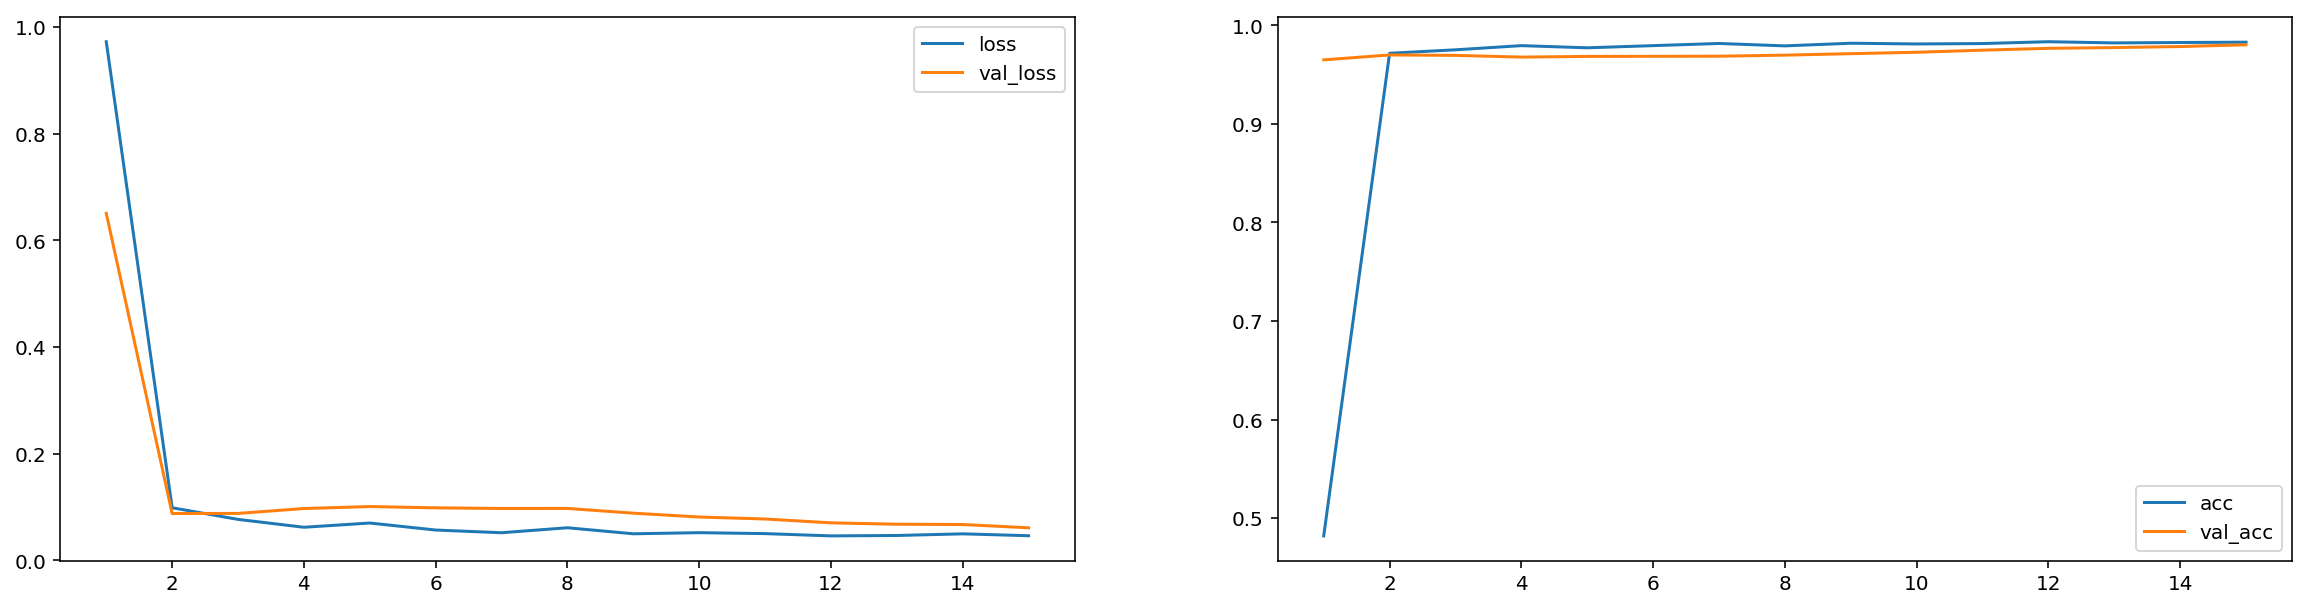

Epoch 00004: val_loss improved from 0.06799 to 0.05838, saving model to basic_model_best.hdf5
143613/143613 [==============================] - 38s - loss: 0.0481 - acc: 0.9825 - val_loss: 0.0584 - val_acc: 0.9806


In [46]:
from keras.callbacks import ModelCheckpoint
checkpointer = ModelCheckpoint(filepath='basic_model_best.hdf5', verbose=1, save_best_only=True)

plot_losses = PlotLosses(plot_interval=1, 
                         evaluate_interval=30, 
                         x_val=dense_matrix_valid, 
                         y_val_categorical=Y_valid)

history = model_sig_nn.fit(dense_matrix_train, 
          Y_train, 
          batch_size = batch_size,
          epochs=epochs, 
          verbose=1, 
          validation_data=(dense_matrix_valid, Y_valid), 
          callbacks=[plot_losses, checkpointer],
         )

# Evaluo set de validation

In [47]:
#model_sig_nn.load_weights('basic_model_best.hdf5')
#tfidf_matrix_valid.shape, Y_valid.shape

pred_valid = model_sig_nn.predict(dense_matrix_valid, verbose = 1)
pred_train = model_sig_nn.predict(dense_matrix_train, verbose = 1)

# loss y accuracy
model_sig_nn.evaluate(dense_matrix_valid, Y_valid)

15808/15958 [============================>.] - ETA: 0s0s 

[0.058380692389302644, 0.9805739939563898]

# ROC Curve

In [48]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle

print("TRAIN ROC AUC: ", roc_auc_score(Y_train, pred_train, average='macro'))
print("VALID ROC AUC: ", roc_auc_score(Y_valid, pred_valid, average='macro'))

# 300 300 5000
#TRAIN ROC AUC:  0.990113354650608
#VALID ROC AUC:  0.9743424026287725

TRAIN ROC AUC:  0.9894741050136338
VALID ROC AUC:  0.9744952441165834


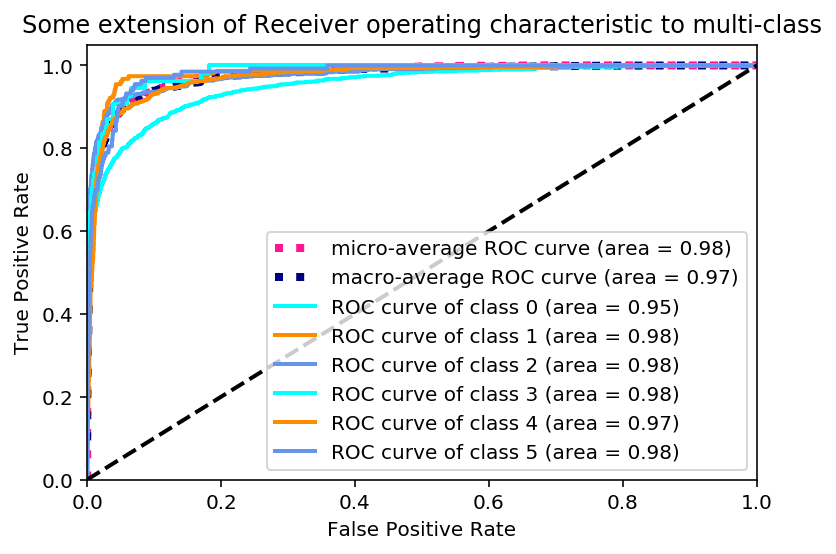

In [49]:
# grafico las curvas de roc general y de cada clase
from matplotlib import pyplot as plt

fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = Y_valid.shape[1]
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_valid[:, i], pred_valid[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
fpr["micro"], tpr["micro"], _ = roc_curve(Y_valid.ravel(), pred_valid.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area
lw = 2
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

**True Positive Rate**:   
The number of times your system was able to classify the positives as positives. 

True positive rate = Correctly Classified Positives/(Correctly Classified as Positives+ Falsely Classified as Negatives)

**False Positive Rate**:  
The number of times your system classified a negative as a positive divided by the total  actual negative instances.


False positive rate = Incorrectly Classified as Positives/(Incorrectly Classified as Positives+ Correctly classified as Negatives )

https://en.wikipedia.org/wiki/Receiver_operating_characteristic

https://datascience.stackexchange.com/questions/15989/micro-average-vs-macro-average-performance-in-a-multiclass-classification-settin/16001

Macro-average: Calcula el score de cada clase y luego promedia  
Micro-average: Suma y luego calcula el score

Micro-average se considera mejor cuando hay desbalce en las clases

# Predict for test

In [50]:
tfidf_matrix_test = tfidf_vectorizer.transform(raw_text_test)

In [51]:
dense_matrix_test = tfidf_matrix_test.todense()

In [52]:
pred = model_sig_nn.predict(dense_matrix_test, verbose=1)

153164/153164 [==============================] - 44s        

In [53]:
1*(pred[0:10]>0.5)

array([[1, 0, 1, 0, 1, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [54]:
submission[list_classes] = pred
submission.to_csv("submission_early_stop_2_epochs.csv", index = False)